In [1]:
# https://youtu.be/q_tpFGHiRgg
# Data from: https://lhncbc.nlm.nih.gov/LHC-publications/pubs/MalariaDatasets.html

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
#Size of our input images
SIZE = 128
batch_size = 64

path_train = r'C:\Users\oswal\Desktop\ImageClassification\elpv-dataset\train_without_bad_images\train'
path_validate = r'C:\Users\oswal\Desktop\ImageClassification\elpv-dataset\train_without_bad_images\validation'
path_bad = r'C:\Users\oswal\Desktop\ImageClassification\elpv-dataset\train_without_good_images'

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    path_train,
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

validation_generator = datagen.flow_from_directory(
    path_validate,
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

anomaly_generator = datagen.flow_from_directory(
    path_bad,
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

Found 838 images belonging to 1 classes.
Found 110 images belonging to 1 classes.
Found 948 images belonging to 1 classes.


In [3]:
#Define the autoencoder. 
#Try to make the bottleneck layer size as small as possible to make it easy for
#density calculations and also picking appropriate thresholds. 

#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

#Decoder
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
#model.summary()

Epoch 1/100
7/7 [==============================] - 7s 156ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 2/100
7/7 [==============================] - 1s 115ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 3/100
7/7 [==============================] - 1s 105ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0218 - val_mse: 0.0218
Epoch 4/100
7/7 [==============================] - 1s 111ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0254 - val_mse: 0.0254
Epoch 5/100
7/7 [==============================] - 1s 110ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0236 - val_mse: 0.0236
Epoch 6/100
7/7 [==============================] - 1s 102ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0231 - val_mse: 0.0231
Epoch 7/100
7/7 [==============================] - 1s 109ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0194 - val_mse: 0.0194
Epoch 8/100
7/7 [==============================] - 1s 110ms/step - loss: 0.0102 - m

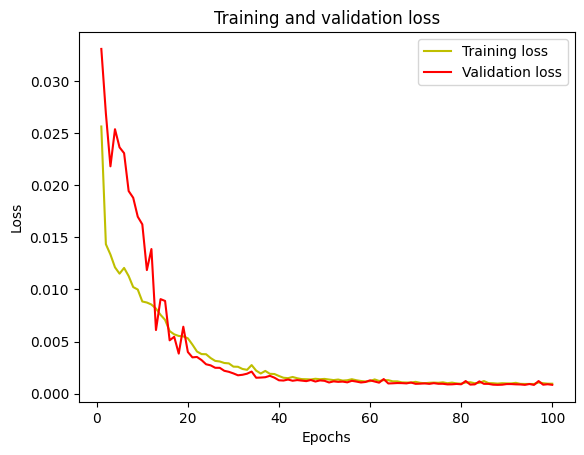

In [4]:
#Fit the model. 
history = model.fit(
        train_generator,
        steps_per_epoch=500 // batch_size,
        epochs=100, # original 1000
        validation_data=validation_generator,
        validation_steps=75 // batch_size,
        shuffle = True)


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [5]:
# Let us examine the reconstruction error between our validation data (good/normal images)
# and the anomaly images
validation_error = model.evaluate(validation_generator)
anomaly_error = model.evaluate(anomaly_generator)

print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)


# Let us extract (or build) the encoder network, with trained weights.
# This is used to get the compressed output (latent space) of the input image. 
# The compressed output is then used to calculate the KDE
encoder_model = Sequential()
encoder_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3), weights=model.layers[0].get_weights()) )
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', weights=model.layers[2].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', weights=model.layers[4].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
#encoder_model.summary()


15/15 [==============================] - 2s 111ms/step - loss: 0.0010 - mse: 0.0010
Recon. error for the validation (normal) data is:  [0.0008341771899722517, 0.0008341771899722517]
Recon. error for the anomaly data is:  [0.0010079150088131428, 0.0010079150088131428]


1/1 [==============================] - 0s 15ms/step
Normal Density:  [2659.371346825124, 2721.2951401526198, 2790.6034317873173, 2792.3833631357984, 2626.3765932604033, 2689.765066958025, 2792.1526543434657, 2666.8114566276768, 2790.5348971480184, 2790.272315964113, 2744.3324903817265, 2714.063850707269, 2793.1263118205516, 2669.120332932999, 2747.9399281861297, 2750.8465303189378, 2681.6663901653, 2654.885967279201, 2778.5357522320483, 2792.494011429289, 2690.80407598446, 2767.5096223735686, 2791.079012615474, 2792.7209224624116, 2713.1866661321124, 2707.083678336431, 2791.8104332471007, 2792.8508188785117, 2792.652520650634, 2789.6413484723776, 2750.771509245757, 2788.831452135522, 2727.421997657304, 2651.870351710556, 2734.891607076699, 2766.9830197479396, 2790.2913972776973, 2793.380318947787, 2700.7701873029455, 2745.847001757098, 2699.3025080164753, 2685.3885189598113, 2661.383004741224, 2730.0213901349916, 2725.5639771089745, 2791.911595932849, 2595.0982828366764, 2662.241426018

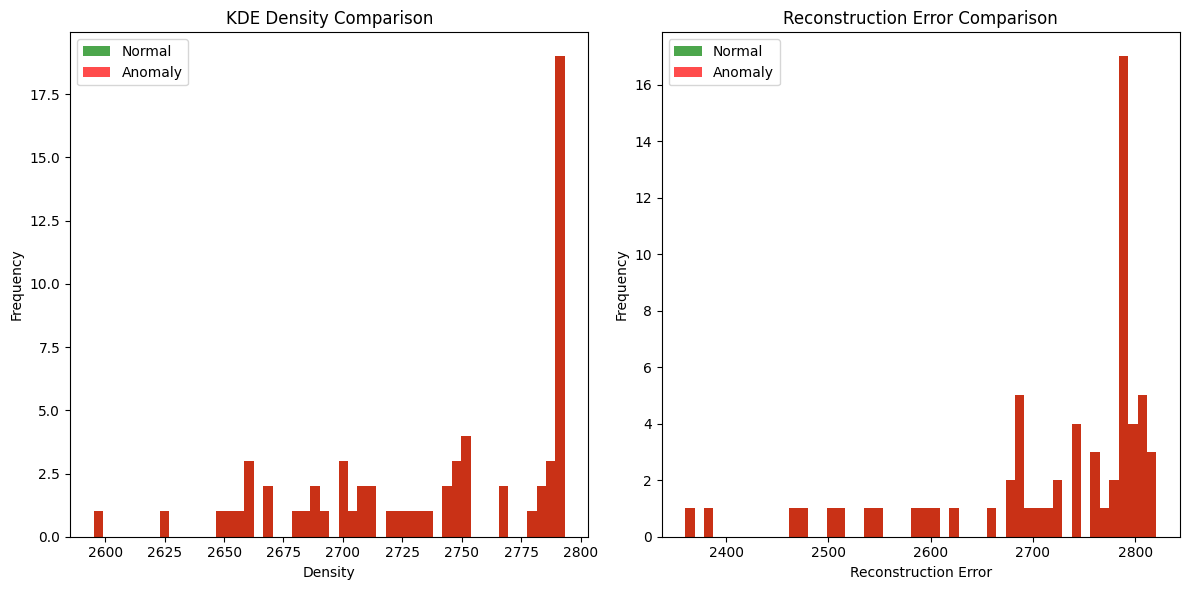

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity

# Get encoded output of input images = Latent space
encoded_images = encoder_model.predict(train_generator)

# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

# Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

# Calculate density and reconstruction error without averaging
def calc_density_and_recon_error(batch_images):
    density_list = []
    recon_error_list = []
    
    for im in range(batch_images.shape[0]):
        img = batch_images[im]
        img = img[np.newaxis, :, :, :] 
        # Get encoded image from encoder
        encoded_img = encoder_model.predict([[img]])
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img]  # Flatten the compressed image
        # Calculate KDE density
        density = kde.score_samples(encoded_img)[0]
        # Get reconstruction error
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction], [[img]], batch_size=1, verbose=0)[0]
        # Append results to lists
        density_list.append(density)
        recon_error_list.append(reconstruction_error)
    
    return density_list, recon_error_list

# Generate batches of normal and anomaly images
validation_batch = validation_generator.next()[0]
anomaly_batch = anomaly_generator.next()[0]

# Calculate density and reconstruction errors for normal (uninfected) and anomaly images
normal_density, normal_recon_error = calc_density_and_recon_error(validation_batch)
anomaly_density, anomaly_recon_error = calc_density_and_recon_error(anomaly_batch)

def plot_density_and_recon_error(normal_density, anomaly_density, normal_recon_error, anomaly_recon_error):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot KDE densities with adjusted bin size and limits
    axes[0].hist(normal_density, bins=50, alpha=0.7, label="Normal", color='green')
    axes[0].hist(anomaly_density, bins=50, alpha=0.7, label="Anomaly", color='red')
    axes[0].set_title("KDE Density Comparison")
    axes[0].set_xlabel("Density")
    axes[0].set_ylabel("Frequency")
    axes[0].legend()
    # Plot reconstruction errors
    axes[1].hist(normal_recon_error, bins=50, alpha=0.7, label="Normal", color='green')
    axes[1].hist(anomaly_recon_error, bins=50, alpha=0.7, label="Anomaly", color='red')
    axes[1].set_title("Reconstruction Error Comparison")
    axes[1].set_xlabel("Reconstruction Error")
    axes[1].set_ylabel("Frequency")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Call the plot function
print("Normal Density: ", normal_density)
print("Anomaly Density: ", anomaly_density)
print("Normal Recon Error: ", normal_recon_error)
print("Anomaly Recon Error: ", anomaly_recon_error)
plot_density_and_recon_error(normal_density, anomaly_density, normal_recon_error, anomaly_recon_error)


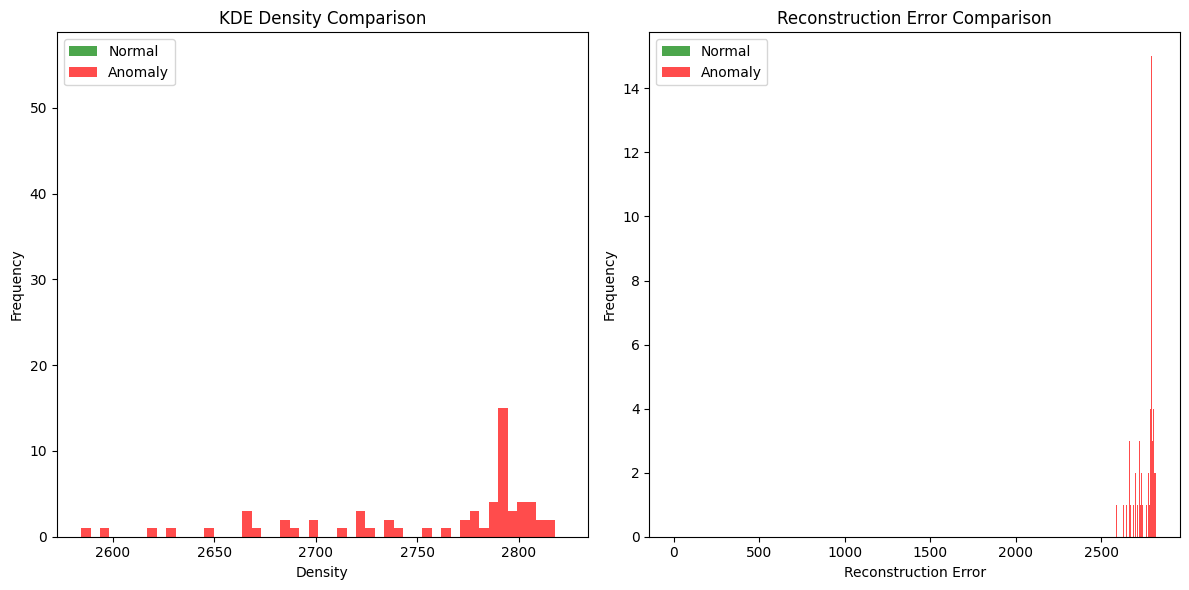

In [47]:
plot_density_and_recon_error(normal_density, anomaly_density, [], anomaly_density)

In [14]:
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

# Get encoded output of input images = Latent space
encoded_images = encoder_model.predict(train_generator)

# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

# Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

# Calculate density and reconstruction error to find their means values for good and anomaly images. 
# We use these mean and sigma to set thresholds. 
def calc_density_and_recon_error(batch_images):
    
    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):
        
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        density = kde.score_samples(encoded_img)[0] # get a density score for the new image
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)
        
    average_density = np.mean(np.array(density_list))  
    stdev_density = np.std(np.array(density_list)) 
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_density, stdev_density, average_recon_error, stdev_recon_error

# Get average and std dev. of density and recon. error for uninfected and anomaly (parasited) images. 
# For this let us generate a batch of images for each. 
validation_batch = train_generator.next()[0]
anomaly_batch = anomaly_generator.next()[0]

normal_values = calc_density_and_recon_error(validation_batch)
anomaly_values = calc_density_and_recon_error(anomaly_batch)


14/14 [==============================] - 1s 91ms/step


AttributeError: 'tuple' object has no attribute 'shape'

In [7]:
import glob
# Modify the function to return True if classification is correct, False otherwise
def check_anomaly(img_path, is_anomaly):
    density_threshold = 2500  # Set this value based on your tuning
    reconstruction_error_threshold = 0.004  # Set this value based on your tuning
    
    img = Image.open(img_path).convert("RGB")
    img = np.array(img.resize((128, 128)))
    img = img / 255.  
    img = img[np.newaxis, :, :, :]
    
    encoded_img = encoder_model.predict([[img]], verbose=0)  # Suppress output 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    density = kde.score_samples(encoded_img)[0]

    reconstruction = model.predict([[img]], verbose=0)  # Suppress output
    reconstruction_error = model.evaluate([reconstruction], [[img]], batch_size=1, verbose=0)[0]
    # Check classification
    is_classified_as_anomaly = density < density_threshold or reconstruction_error > reconstruction_error_threshold
    # Return True if classification matches expected label
    return is_classified_as_anomaly == is_anomaly

# Function to test all images and calculate separate accuracy scores
def evaluate_accuracy(path_test_good, path_test_bad):
    correct_normal = 0
    correct_anomaly = 0
    # Total number of images in each category
    total_normal = len(path_test_good)
    total_anomaly = len(path_test_bad)
    # Test all normal images (good images)
    for img_path in path_test_good:
        if check_anomaly(img_path, is_anomaly=False):
            correct_normal += 1
    # Test all anomaly images (bad images)
    for img_path in path_test_bad:
        if check_anomaly(img_path, is_anomaly=True):
            correct_anomaly += 1
    # Calculate accuracy for normal and anomaly images
    normal_accuracy = correct_normal / total_normal if total_normal > 0 else 0
    anomaly_accuracy = correct_anomaly / total_anomaly if total_anomaly > 0 else 0
    # Print accuracy scores
    print(f"Normal Image Accuracy: {normal_accuracy * 100:.2f}%")
    print(f"Anomaly Image Accuracy: {anomaly_accuracy * 100:.2f}%")

    return normal_accuracy, anomaly_accuracy

# Example usage:
path_test_good = glob.glob(r'C:\Users\oswal\Desktop\ImageClassification\elpv-dataset\test_images\good\*')
path_test_bad = glob.glob(r'C:\Users\oswal\Desktop\ImageClassification\elpv-dataset\test_images\bad\*')

# Call the function to evaluate accuracy
evaluate_accuracy(path_test_good, path_test_bad)


Normal Image Accuracy: 100.00%
Anomaly Image Accuracy: 10.71%


(1.0, 0.10714285714285714)